In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch

torch.set_default_dtype(torch.float32)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'

In [4]:
data_dict = torch.load('data/summarized_neutron_data_w_bkg_260meV_ML.pt')
print(data_dict.keys())

/tmp/ipykernel_1442396/252732357.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_dict = torch.load('data/summarized_neutron_data_w_bkg_260meV_ML.pt')


dict_keys(['grid', 'S', 'background', 'background_dict'])


In [6]:
from src.sqw import SpecNeuralRepr
model_sqw = SpecNeuralRepr.load_from_checkpoint(
    'version_14896845/checkpoints/epoch=7160-step=343728.ckpt')

/global/homes/e/edmundxu/.conda/envs/backsub/lib/python3.9/site-packages/lightning/fabric/utilities/cloud_io.py:57: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


In [7]:
from src.dataset import NeighborDataset
from torch.utils.data import DataLoader

In [8]:
hklw_grid = torch.vstack([_.unsqueeze(0) for _ in torch.meshgrid(*[v for k, v in data_dict['grid'].items()], indexing='ij')]).permute(1, 2, 3, 4, 0)

In [9]:
from src.dataset import NeighborDataset
from torch.utils.data import DataLoader

In [10]:
dataset = NeighborDataset(hklw_grid, data_dict['S'], neighbor_range=4)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

In [11]:
from src.kernel import L_Kernel

In [12]:
# ckpt_path = 'lightning_logs/sf_300.0/version_0/checkpoints/sf_300.0-epoch=6-step=2950.ckpt'
# ckpt_path = 'lightning_logs/sf_1.0/version_0/checkpoints/sf_1.0-epoch=9-step=4160.ckpt'
ckpt_path = 'lightning_logs/sf_net/version_1/checkpoints/last.ckpt'
model_config = torch.load(ckpt_path)['hyper_parameters']['model_config']

/tmp/ipykernel_1442396/3755946692.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_config = torch.load(ckpt_path)['hyper_parameters']['model_config']


FileNotFoundError: [Errno 2] No such file or directory: 'lightning_logs/sf_net/version_1/checkpoints/last.ckpt'

In [ ]:
model_sqw.params = torch.tensor([29.0, 1.68])
L_model = L_Kernel(forward_model=model_sqw, model_config=model_config).to(device)
L_model.load_state_dict(torch.load(ckpt_path)['state_dict'])

<All keys matched successfully>

In [ ]:
print(L_model.kernel_net.scale_factor)

AttributeError: 'KernelNet' object has no attribute 'scale_factor'

In [ ]:
from src.data_utils import get_neighbors

In [ ]:
batch = next(iter(dataloader))
center_pts = batch['center_pts']

In [ ]:
from src.qpath import linspace_2D_equidistant

kpts = torch.from_numpy(linspace_2D_equidistant([[0,0],[0.5,0],[0.5,0.5],[0,0]], 100))
wpts = data_dict['grid']['w_grid']
qw_coords = []
for _l in data_dict['grid']['l_grid']:
    _qw_coords = torch.cat([
        kpts.unsqueeze(0).expand(wpts.shape[0], -1, -1),
        _l * torch.ones(wpts.shape[0], kpts.shape[0], 1),
        wpts.view(wpts.shape[0], -1).unsqueeze(1).expand(-1, kpts.shape[0], -1)
       ], dim=2)
    qw_coords.append(_qw_coords)
    
_l = data_dict['grid']['l_grid'][0]

params = torch.tensor([29, 1.7])

# x_input = torch.zeros(wpts.shape[0], kpts.shape[0], 6)
# x_input[...,:4] = torch.cat([
#     kpts.unsqueeze(0).expand(wpts.shape[0], -1, -1),
#     _l * torch.ones(wpts.shape[0], kpts.shape[0], 1),
#     wpts.view(wpts.shape[0], -1).unsqueeze(1).expand(-1, kpts.shape[0], -1)
#    ], dim=2)
# x_input[...,4:] = params


center_pts = torch.vstack([_.unsqueeze(0) for _ in qw_coords])

In [ ]:
s_sig = torch.zeros(center_pts.view(-1, 4).shape[:-1]+(1,))
s_bkg = torch.zeros_like(s_sig)

In [ ]:
from tqdm import tqdm
import numpy as np

In [ ]:
from src.experiment import NeutronExperiment


experiment_config = {
    "q_grid": tuple([data_dict['grid'][_grid] for _grid in ['h_grid', 'k_grid', 'l_grid']]),
    "w_grid": data_dict['grid']['w_grid'],
    "S_grid": data_dict['S'],
    "S_scale_factor": 1.
}

experiment = NeutronExperiment(**experiment_config)
# experiment.prepare_experiment(hklw_grid)

In [ ]:
batches = np.array_split(np.arange(center_pts.view(-1,4).shape[0]), 1000)

for i, batch_idx in tqdm(enumerate(batches), total=len(batches)):
    
    _center_pts = center_pts.view(-1,4)[batch_idx]
    _mask = experiment.get_mask_on_coords(_center_pts.cpu().numpy())
    
    sample_pts, _ = get_neighbors(_center_pts, dim=4, neighbor_range=3, exclude_corner=True, deltas=dataset.deltas)
    s_sample = model_sqw.forward_qw(sample_pts)
    with torch.no_grad():
        kappa = L_model.kernel_net(_center_pts.to(L_model.dtype).to(L_model.device))
        _s_bkg = L_model.bkgd_net(_center_pts.to(L_model.dtype).to(L_model.device)).cpu()
    _s_sig = torch.einsum('ij, ij -> i', kappa, s_sample[:,L_model.kernel_net.kernel_mask_flat]).unsqueeze(-1)
    s_sig[batch_idx] = _s_sig.cpu() * torch.from_numpy(_mask).unsqueeze(-1)
    s_bkg[batch_idx] = _s_bkg * torch.from_numpy(_mask).unsqueeze(-1)

 46%|████▋     | 465/1000 [00:32<00:35, 15.05it/s]

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.imshow(s_bkg.reshape(center_pts.shape[:-1]).detach().cpu().sum(0), origin='lower', aspect='auto', vmax=20)

In [ ]:
plt.imshow(s_sig.reshape(center_pts.shape[:-1]).sum(0), origin='lower', aspect='auto')

In [ ]:
plt.imshow(model_sqw.forward_qw(center_pts.to(device)).cpu().sum(0), origin='lower', aspect='auto')

In [ ]:
S_exp = 0.
mask_exp = 0.
for _qw_coords in qw_coords:
    S_exp += experiment.get_measurements_on_coords(_qw_coords)
    mask_exp += experiment.get_mask_on_coords(_qw_coords)

In [ ]:
plt.imshow(S_exp, origin='lower', aspect='auto', vmax=300)

In [ ]:
S_exp_pred = (s_sig+s_bkg).reshape(center_pts.shape[:-1]).detach().cpu().sum(0)
plt.imshow(S_exp_pred, origin='lower', aspect='auto', vmax=300)

In [ ]:
plt.imshow(np.abs(S_exp_pred - S_exp), origin='lower', aspect='auto')
plt.colorbar()

In [ ]:
S_mask = data_dict['S'] > 1e-3

In [ ]:
batches = np.array_split(torch.where(S_mask.reshape(-1))[0], 2500)

In [ ]:
center_pts_full_grid = hklw_grid.reshape(-1,4)
s_sig_full_grid = torch.zeros((data_dict['S'].numel(), 1,))
s_bkg_full_grid = torch.zeros_like(s_sig_full_grid)

batches = np.array_split(torch.where(S_mask.reshape(-1))[0], 2000)

for i, batch_idx in tqdm(enumerate(batches), total=len(batches)):
    
    _center_pts = center_pts_full_grid[batch_idx]
    _mask = experiment.get_mask_on_coords(_center_pts.cpu().numpy())
    
    sample_pts, _ = get_neighbors(_center_pts, dim=4, neighbor_range=3, exclude_corner=True, deltas=dataset.deltas)
    s_sample = model_sqw.forward_qw(sample_pts)
    with torch.no_grad():
        kappa = L_model.kernel_net(_center_pts.to(L_model.dtype).to(L_model.device))
        _s_bkg = L_model.bkgd_net(_center_pts.to(L_model.dtype).to(L_model.device)).cpu()
    _s_sig = torch.einsum('ij, ij -> i', kappa, s_sample[:,L_model.kernel_net.kernel_mask_flat]).unsqueeze(-1)
    s_sig_full_grid[batch_idx] = _s_sig.cpu() * torch.from_numpy(_mask).unsqueeze(-1)
    s_bkg_full_grid[batch_idx] = _s_bkg * torch.from_numpy(_mask).unsqueeze(-1)

In [ ]:
plt.imshow(s_sig_full_grid.reshape(hklw_grid.shape[:-1]).sum(-1).sum(-1))

NameError: name 'plt' is not defined

In [ ]:
plt.imshow(s_bkg_full_grid.reshape(hklw_grid.shape[:-1]).sum(-1).sum(-1))

NameError: name 'plt' is not defined

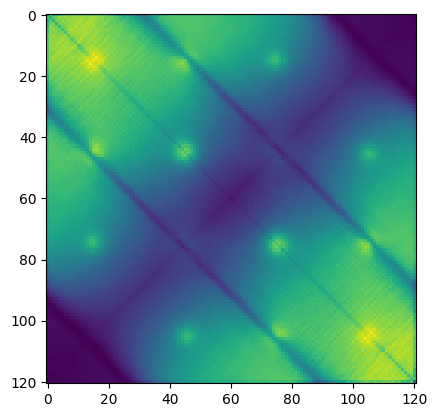

In [ ]:
plt.imshow((s_bkg_full_grid+s_sig_full_grid).reshape(hklw_grid.shape[:-1]).sum(-1).sum(-1))